<a href="https://colab.research.google.com/github/goodnasubi/pytorch-lesson/blob/master/PyTorch_Introduction_with_Colab_kai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Deep Learning for Computer Vision using PyTorch

### [Kevin McGuinness](http://www.eeng.dcu.ie/~mcguinne/), DCU

kevin.mcguinness@dcu.ie


---




**Today:**

- Introduce the free [Google Colabratory](https://colab.research.google.com) cloud service
- Work with the [PyTorch](https://pytorch.org/) deep learning framework
- Show how to specify a simple deep learning model for handwritten digit classification
- Show how to train the model on a GPU
- Understand data loaders and datasets in PyTorch
- Understand training data, validation data, test data
- Plot learning curves
- Track progress
- Error analysis

In [1]:
import sys
print(sys.version)

3.6.7 (default, Oct 22 2018, 11:32:17) 
[GCC 8.2.0]


# Enable GPU acceleration

Open to the Edit menu and select *Notebook settings* and then select *GPU* under hardware accelerator.

Change the line below to ``device = 'cpu'`` to run on the CPU instead.

In [0]:
# make sure to enable GPU acceleration!
device = 'cuda'

# Install PyTorch 

Google colab doesn't have PyTorch installed by default, but it can be easily installed using the Python package manager *pip*. 

This will take a minute to install.

In [3]:
!pip3 install torch torchvision

# Import packages

Find the PyTorch docs at https://pytorch.org/docs/stable/index.html 

Tutorials: https://pytorch.org/tutorials/

In [0]:
import numpy as np

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms

from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt


In [4]:
print('PyTorch version:', torch.__version__)

PyTorch version: 1.1.0


In [0]:
# Set random seed for reproducability
torch.manual_seed(271828)
np.random.seed(271728)

# Specify a model architecture

We will use a simple CNN with two conv layers, one pooling layer, two fully connected, and some dropout.

![Model Architecture](http://www.eeng.dcu.ie/~mcguinne/media/cnn.png =400x)

In [0]:
class SimpleCNN(nn.Module):

    def __init__(self, num_channels=1, num_classes=10):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(num_channels, 32, 3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 32, 3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(2)
        self.drop1 = nn.Dropout(0.25)
        self.fc1 = nn.Linear(14*14*32, 128)
        self.drop2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)
        
    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.relu(self.conv2(X))
        X = self.pool1(X)
        X = self.drop1(X)
        X = X.reshape(-1, 14*14*32)
        X = F.relu(self.fc1(X))
        X = self.drop2(X)
        X = self.fc2(X)
        return X  # logits      

relu の代わりに 
*  ❌softshrinkを使ってみる
*  PReLU


In [0]:
class SimpleCNN(nn.Module):

    def __init__(self, num_channels=1, num_classes=10):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(num_channels, 32, 3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 32, 3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(2)
        self.drop1 = nn.Dropout(0.25)
        self.fc1 = nn.Linear(14*14*32, 128)
        self.drop2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)
        #self.ss = nn.Softshrink(lambd=0.7)
        #self.ss = nn.PReLU()
        #self.ss = nn.ReLU()
        self.ss = nn.ReLU6()
        
    def forward(self, X):
        X = self.ss(self.conv1(X))
        X = self.ss(self.conv2(X))
        X = self.pool1(X)
        X = self.drop1(X)
        X = X.reshape(-1, 14*14*32)
        X = self.ss(self.fc1(X))
        X = self.drop2(X)
        X = self.fc2(X)
        return X  # logits      

# Load the datasets

We also need to specify a **transform** here to convert images to torch tensors.

I'm adding a **normalization** transform here too so that the images have mean zero and unit variance. This is optional. For some problems (models/datasets) proper normalization is important for performance. For others (e.g. models with batch normalization early on), the importance of normalization is less.

PyTorch comes with a built-in dataset class for the MNIST digit classification task in the (optional) ``torchvision`` package. It also has built-in for other common datasets and tasks like CIFAR-10 and ImageNet. See: https://pytorch.org/docs/stable/torchvision/datasets.html


In [0]:

# transform for the training data
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.1307], [0.3081])
])

# use the same transform for the validation data
valid_transform = train_transform

# load datasets, downloading if needed
train_set = MNIST('./data/mnist', train=True, download=True, 
                  transform=train_transform)
valid_set = MNIST('./data/mnist', train=False, download=True, 
                  transform=valid_transform)

In [8]:
print(train_set.train_data.shape)
print(valid_set.test_data.shape)

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


## Some notes about the training data

There are two subsets of the data being used here:

- **Training data** Data that is used to optimize model parameters
- **Validation data** Data that is used for model selection (choosing hyperparameters).

The data that we test on during training to monitor progress is validation data, since it can be used to tune the model architecture (number of layers, etc) and other hyperparameters.

Usually, we would keep another separate **test set** for testing the final model in order to get an unbiased estimate of *out of sample* accuracy. Unfortunately, MNIST doesn't have a separate test set and it is common practice on this task to use the validation set both for validation and test. 

**Warning**: This is considered BAD PRACTICE in most situations!


# Preview the data

Let's look at a sample of the training data. 

Here I'm using some indexing tricks (reshaping and permuting axes) to put the first 64 digits in the dataset into a grid.

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


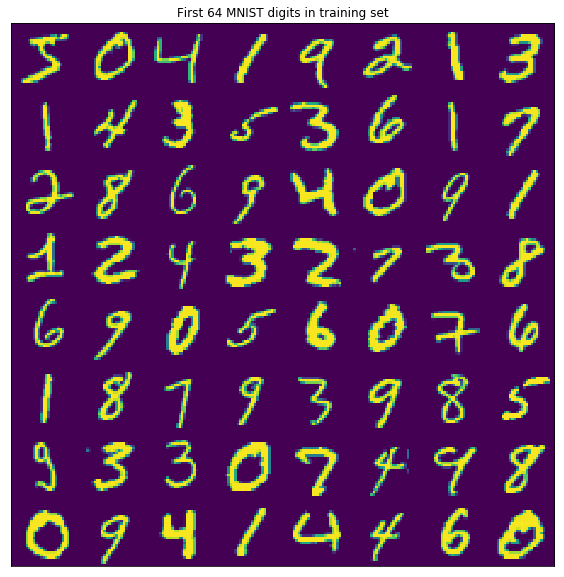

Labels: [5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9 4 0 9 1 1 2 4 3 2 7 3 8 6 9 0 5 6
 0 7 6 1 8 7 9 3 9 8 5 9 3 3 0 7 4 9 8 0 9 4 1 4 4 6 0]


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


In [9]:
plt.figure(figsize=(10,10))

sample = train_set.train_data[:64]
# shape (64, 28, 28)
sample = sample.reshape(8,8,28,28)
# shape (8, 8, 28, 28)
sample = sample.permute(0,2,1,3)
# shape (8, 28, 8, 28)
sample = sample.reshape(8*28,8*28)
# shape (8*28, 8*28)
plt.imshow(sample)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.title('First 64 MNIST digits in training set')
plt.show()

print('Labels:', train_set.train_labels[:64].numpy())

# Setup the data loaders

PyTorch provides a [DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) class in `torch.utils.data` that can be used to manage loading data from datasets using multiple worker threads and packaging data into datasets. It also provides data **shuffling** and **sampling** strategies.

Having multiple threads to load the data improve the performance when training larger models on large datasets since the CPU threads can be busy loading and transforming data while the GPU is doing forward and backward propagation.


**Note**: The `Dataset` and `DataLoader` classes are not mandatory in PyTorch; you can write your own data loading mechanisms. 

In [0]:
train_loader = DataLoader(train_set, batch_size=256, num_workers=0, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=512, num_workers=0, shuffle=False)

# Add some utilities 

Usually when training a deep learning model, you want to keep track of the loss. However, the **loss on individual batches is quite noisy**, so I usually use an **exponentially decayed moving average** to smooth out individual fluctuations in each batch and make general trends more easy to see. 

At validation time you usually want to find the average loss over the full dataset, so a running average (cumulative moving average) is more appropriate.

Here we define two classes to take care of this.

In [0]:
class AverageBase(object):
    
    def __init__(self, value=0):
        self.value = float(value) if value is not None else None
       
    def __str__(self):
        return str(round(self.value, 4))
    
    def __repr__(self):
        return self.value
    
    def __format__(self, fmt):
        return self.value.__format__(fmt)
    
    def __float__(self):
        return self.value
    

class RunningAverage(AverageBase):
    """
    Keeps track of a cumulative moving average (CMA).
    """
    
    def __init__(self, value=0, count=0):
        super(RunningAverage, self).__init__(value)
        self.count = count
        
    def update(self, value):
        self.value = (self.value * self.count + float(value))
        self.count += 1
        self.value /= self.count
        return self.value


class MovingAverage(AverageBase):
    """
    An exponentially decaying moving average (EMA).
    """
    
    def __init__(self, alpha=0.99):
        super(MovingAverage, self).__init__(None)
        self.alpha = alpha
        
    def update(self, value):
        if self.value is None:
            self.value = float(value)
        else:
            self.value = self.alpha * self.value + (1 - self.alpha) * float(value)
        return self.value

## Progress monitor

I usually use [tqdm](https://github.com/tqdm/tqdm) for monitoring progress on the console and in Jupyter notebooks. But unfortunately, it doesn't work very well with Collab at the moment, so here we create a custom progress monitor class that uses the HTML and [display facilities of IPython](https://ipython.org/ipython-doc/3/api/generated/IPython.display.html) to show a progress bar.

In [0]:
from IPython.display import HTML, display

class ProgressMonitor(object):
    """
    Custom IPython progress bar for training
    """
    
    tmpl = """
        <p>Loss: {loss:0.4f}   {value} / {length}</p>
        <progress value='{value}' max='{length}', style='width: 100%'>{value}</progress>
    """

    def __init__(self, length):
        self.length = length
        self.count = 0
        self.display = display(self.html(0, 0), display_id=True)
        
    def html(self, count, loss):
        return HTML(self.tmpl.format(length=self.length, value=count, loss=loss))
        
    def update(self, count, loss):
        self.count += count
        self.display.update(self.html(self.count, loss))

# Instantiate the model

Create an instance of the model and move it (memory and operations) to the CUDA device.

In [14]:
model = SimpleCNN()
model.to(device)

SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout(p=0.25)
  (fc1): Linear(in_features=6272, out_features=128, bias=True)
  (drop2): Dropout(p=0.5)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (ss): ReLU6()
)

# Train the model

We're now ready to train!

- First create a loss function (called `criterion` below) that will be used during optimization.
- Then create an optimizer. Here we just use simple stochastic gradient descent with nesterov momentum. More advanced first order optimizers are also available like [Adam](https://arxiv.org/abs/1412.6980). See the [torch.optim](https://pytorch.org/docs/stable/optim.html) package for more details.
- Finally, code up the train loop. 

Each pass through the training loop is called an epoch (an epoch is when every training example has been seen once). 

There are two parts to the loop:
- **Train phase**: where batches of data are loaded from the training set and the model parameters are optimized using backpropagation to compute gradients.
- **Validation phase**: where batches of data are loaded from the validation set and out of sample error is estimated using this data.

In [0]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True)

In [0]:
def save_checkpoint(optimizer, model, epoch, filename):
    checkpoint_dict = {
        'optimizer': optimizer.state_dict(),
        'model': model.state_dict(),
        'epoch': epoch
    }
    torch.save(checkpoint_dict, filename)


def load_checkpoint(optimizer, model, filename):
    checkpoint_dict = torch.load(filename)
    epoch = checkpoint_dict['epoch']
    model.load_state_dict(checkpoint_dict['model'])
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint_dict['optimizer'])
    return epoch

In [0]:
!mkdir -p checkpoints

In [0]:
def train(optimizer, model, num_epochs=10, first_epoch=1):
    
    criterion = nn.CrossEntropyLoss()

    train_losses = []
    valid_losses = []

    for epoch in range(first_epoch, first_epoch + num_epochs):
        print('Epoch', epoch)

        # train phase
        model.train()

        # create a progress bar
        progress = ProgressMonitor(length=len(train_set))

        train_loss = MovingAverage()

        for batch, targets in train_loader:
            # Move the training data to the GPU
            batch = batch.to(device)
            targets = targets.to(device)

            # clear previous gradient computation
            optimizer.zero_grad()

            # forward propagation
            predictions = model(batch)

            # calculate the loss
            loss = criterion(predictions, targets)

            # backpropagate to compute gradients
            loss.backward()

            # update model weights
            optimizer.step()

            # update average loss
            train_loss.update(loss)

            # update progress bar
            progress.update(batch.shape[0], train_loss)

        print('Training loss:', train_loss)
        train_losses.append(train_loss.value)


        # validation phase
        model.eval()

        valid_loss = RunningAverage()

        # keep track of predictions
        y_pred = []

        # We don't need gradients for validation, so wrap in 
        # no_grad to save memory
        with torch.no_grad():

            for batch, targets in valid_loader:

                # Move the training batch to the GPU
                batch = batch.to(device)
                targets = targets.to(device)

                # forward propagation
                predictions = model(batch)

                # calculate the loss
                loss = criterion(predictions, targets)

                # update running loss value
                valid_loss.update(loss)

                # save predictions
                y_pred.extend(predictions.argmax(dim=1).cpu().numpy())

        print('Validation loss:', valid_loss)
        valid_losses.append(valid_loss.value)

        # Calculate validation accuracy
        y_pred = torch.tensor(y_pred, dtype=torch.int64)
        accuracy = torch.mean((y_pred == valid_set.test_labels).float())
        print('Validation accuracy: {:.4f}%'.format(float(accuracy) * 100))

        # Save a checkpoint
        checkpoint_filename = 'checkpoints/mnist-{:03d}.pkl'.format(epoch)
        save_checkpoint(optimizer, model, epoch, checkpoint_filename)
    
    return train_losses, valid_losses, y_pred

##Checkpointing

The above code saves a **snapshot** of the model after each epoch.

- It is a good idea to save checkpoints (snapshots) of your model after each epoch so that you can resume training if there is a hardware/software failure that interrupts training. 
- This is **especially important for larger problems** where training for a single epoch can take hours and the full optimization can take weeks.
- Also allows you to implement **early stopping** easily: simply keep the snapshot corresponding to the model with minimum validation loss (or maximum validation accuracy).

**NB**: it's usually a good idea to save both the model and the optimizer state!

In [18]:
train_losses, valid_losses, y_pred = train(optimizer, model, num_epochs=10)

Epoch 1


Training loss: 0.5645
Validation loss: 0.1671
Validation accuracy: 95.1200%
Epoch 2


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


Training loss: 0.2131
Validation loss: 0.0975
Validation accuracy: 96.9800%
Epoch 3


Training loss: 0.1569
Validation loss: 0.0692
Validation accuracy: 97.8400%
Epoch 4


Training loss: 0.1233
Validation loss: 0.0616
Validation accuracy: 98.0100%
Epoch 5


Training loss: 0.0996
Validation loss: 0.052
Validation accuracy: 98.3900%
Epoch 6


Training loss: 0.0884
Validation loss: 0.0446
Validation accuracy: 98.4800%
Epoch 7


Training loss: 0.0776
Validation loss: 0.0417
Validation accuracy: 98.6700%
Epoch 8


Training loss: 0.0792
Validation loss: 0.0384
Validation accuracy: 98.7900%
Epoch 9


Training loss: 0.0662
Validation loss: 0.0352
Validation accuracy: 98.8400%
Epoch 10


Training loss: 0.0593
Validation loss: 0.0345
Validation accuracy: 98.8900%


# Plot the learning curves

Here we plot the learning curves after training. Note that you can also use [Tensorboard](https://www.tensorflow.org/guide/summaries_and_tensorboard) with PyTorch using the [tensorboardX](https://github.com/lanpa/tensorboardX) library. 

Tensorboard, part of the tensorflow framework, allows you to visualize the learning curves (and any other data you want to track) in real time as the model trains. Running tensorboard with Colab needs a [few tricks to get working](https://www.dlology.com/blog/quick-guide-to-run-tensorboard-in-google-colab/) though. 


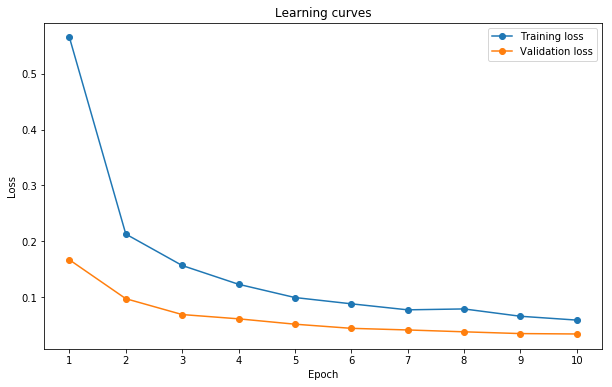

In [19]:
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(10,6))
plt.plot(epochs, train_losses, '-o', label='Training loss')
plt.plot(epochs, valid_losses, '-o', label='Validation loss')
plt.legend()
plt.title('Learning curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.show()

In [20]:
# for variety, lets use altair to do the plot
import pandas as pd
import altair as alt

# create a pandas dataframe for the loss
df = pd.DataFrame({
    'epoch': range(1, len(train_losses) + 1),
    'train': train_losses,
    'valid': valid_losses
})

# unpivot to have cols [epoch, dataset, loss]
df = df.melt(id_vars=['epoch'],
             value_vars=['train', 'valid'],
             value_name='loss',
             var_name='dataset')

# line plot with altair
alt.Chart(df).mark_line(point=True)\
    .encode(x='epoch', y='loss', color='dataset')\
    .interactive()    

Chart({
  data:     epoch dataset      loss
  0       1   train  0.564540
  1       2   train  0.213071
  2       3   train  0.156907
  3       4   train  0.123320
  4       5   train  0.099633
  5       6   train  0.088403
  6       7   train  0.077632
  7       8   train  0.079245
  8       9   train  0.066151
  9      10   train  0.059294
  10      1   valid  0.167079
  11      2   valid  0.097548
  12      3   valid  0.069199
  13      4   valid  0.061559
  14      5   valid  0.051976
  15      6   valid  0.044568
  16      7   valid  0.041670
  17      8   valid  0.038351
  18      9   valid  0.035182
  19     10   valid  0.034478,
  encoding: FacetedEncoding({
    color: Color({
      shorthand: 'dataset'
    }),
    x: X({
      shorthand: 'epoch'
    }),
    y: Y({
      shorthand: 'loss'
    })
  }),
  mark: MarkDef({
    point: True,
    type: 'line'
  }),
  selection: {'selector001': SelectionDef({
    bind: 'scales',
    encodings: ['x', 'y'],
    type: 'interval'
  })}
})

# Error analysis

In [59]:
num_errors = torch.sum((y_pred != valid_set.test_labels).float())
print('Validation errors {} (out of {})'.format(int(num_errors), len(valid_set)))

Validation errors 101 (out of 10000)


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [60]:
# pull out examples of mistakes in the valid set
error_indicator = y_pred != valid_set.test_labels
error_examples = valid_set.test_data[error_indicator, :, :]

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


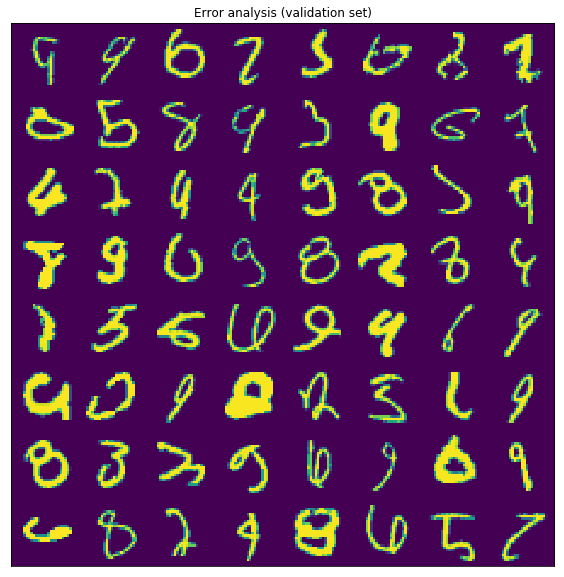

y_true: [9 9 6 2 5 6 8 2 0 5 8 9 3 8 6 7 4 7 9 4 9 8 5 9 8 9 0 9 8 2 8 9 1 5 5 6 9
 4 6 9 9 0 9 2 2 5 6 9 8 3 3 9 6 9 6 9 6 8 2 4 8 6 5 7]
y_pred: [5 4 0 7 3 0 2 1 5 8 7 7 5 9 5 3 6 2 4 9 5 0 3 4 7 3 6 5 0 7 3 4 7 3 6 0 8
 9 1 8 0 2 4 0 4 3 1 4 0 8 2 5 0 7 0 1 4 5 7 9 9 0 2 8]


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [61]:
plt.figure(figsize=(10,10))

sample = error_examples[:64]
# shape (64, 28, 28)
sample = sample.reshape(8,8,28,28)
# shape (8, 8, 28, 28)
sample = sample.permute(0,2,1,3)
# shape (8, 28, 8, 28)
sample = sample.reshape(8*28,8*28)
# shape (8*28, 8*28)
plt.imshow(sample)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.title('Error analysis (validation set)')
plt.show()

print('y_true:', valid_set.test_labels[error_indicator][:64].numpy())
print('y_pred:', y_pred[error_indicator][:64].numpy())

# Resuming training

In [53]:
ls checkpoints

mnist-001.pkl  mnist-003.pkl  mnist-005.pkl  mnist-007.pkl  mnist-009.pkl
mnist-002.pkl  mnist-004.pkl  mnist-006.pkl  mnist-008.pkl  mnist-010.pkl


In [54]:
epoch = load_checkpoint(optimizer, model, 'checkpoints/mnist-010.pkl')
print('Resuming training from epoch', epoch)
train_losses, valid_losses, y_pred = train(optimizer, model, num_epochs=3, first_epoch=epoch)


Resuming training from epoch 10
Epoch 10


Training loss: 0.0432
Validation loss: 0.0345
Validation accuracy: 98.8600%
Epoch 11


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


Training loss: 0.0435
Validation loss: 0.033
Validation accuracy: 98.8800%
Epoch 12


Training loss: 0.041
Validation loss: 0.0336
Validation accuracy: 98.8700%


In [55]:
epoch = load_checkpoint(optimizer, model, 'checkpoints/mnist-012.pkl')
print('Resuming training from epoch', epoch)
train_losses, valid_losses, y_pred = train(optimizer, model, num_epochs=6, first_epoch=epoch)


Resuming training from epoch 12
Epoch 12


Training loss: 0.0406
Validation loss: 0.033
Validation accuracy: 98.8200%
Epoch 13


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


Training loss: 0.0365
Validation loss: 0.03
Validation accuracy: 99.0800%
Epoch 14


Training loss: 0.0363
Validation loss: 0.0337
Validation accuracy: 98.9200%
Epoch 15


Training loss: 0.0345
Validation loss: 0.0333
Validation accuracy: 98.9500%
Epoch 16


Training loss: 0.0315
Validation loss: 0.0318
Validation accuracy: 99.0100%
Epoch 17


Training loss: 0.0299
Validation loss: 0.03
Validation accuracy: 98.9900%


# Using colab widgets to monitor loss in the training loop

Let's see how we could modify the training loop to use [colab widgets](https://colab.research.google.com/notebooks/widgets.ipynb) to monitor the loss.

In [0]:
from google.colab import widgets

In [0]:
def train(optimizer, model, num_epochs=10, first_epoch=1):
    
    # create a 1x1 grid to display the loss and progress
    grid = widgets.Grid(2,1)
    
    criterion = nn.CrossEntropyLoss()

    train_losses = []
    valid_losses = []

    for epoch in range(first_epoch, first_epoch + num_epochs):
        print('Epoch', epoch)

        # train phase
        model.train()

        # create a progress bar
        with grid.output_to(0,0):
            progress = ProgressMonitor(length=len(train_set))

        train_loss = MovingAverage()

        for batch, targets in train_loader:
            # Move the training data to the GPU
            batch = batch.to(device)
            targets = targets.to(device)

            # clear previous gradient computation
            optimizer.zero_grad()

            # forward propagation
            predictions = model(batch)

            # calculate the loss
            loss = criterion(predictions, targets)

            # backpropagate to compute gradients
            loss.backward()

            # update model weights
            optimizer.step()

            # update average loss
            train_loss.update(loss)

            # update progress bar
            with grid.output_to(0,0):
                progress.update(batch.shape[0], train_loss)

        print('Training loss:', train_loss)
        train_losses.append(train_loss.value)


        # validation phase
        model.eval()

        valid_loss = RunningAverage()

        # keep track of predictions
        y_pred = []

        # We don't need gradients for validation, so wrap in 
        # no_grad to save memory
        with torch.no_grad():

            for batch, targets in valid_loader:

                # Move the training batch to the GPU
                batch = batch.to(device)
                targets = targets.to(device)

                # forward propagation
                predictions = model(batch)

                # calculate the loss
                loss = criterion(predictions, targets)

                # update running loss value
                valid_loss.update(loss)

                # save predictions
                y_pred.extend(predictions.argmax(dim=1).cpu().numpy())

        print('Validation loss:', valid_loss)
        valid_losses.append(valid_loss.value)

        # Calculate validation accuracy
        y_pred = torch.tensor(y_pred, dtype=torch.int64)
        accuracy = torch.mean((y_pred == valid_set.test_labels).float())
        print('Validation accuracy: {:.4f}%'.format(float(accuracy) * 100))

        # Save a checkpoint
        checkpoint_filename = 'checkpoints/mnist-{:03d}.pkl'.format(epoch)
        save_checkpoint(optimizer, model, epoch, checkpoint_filename)
        
        
        # Plot loss
        with grid.output_to(1, 0):
            grid.clear_cell()
            plt.figure(figsize=(10,6))
            epochs = range(first_epoch, epoch + 1)
            plt.plot(epochs, train_losses, '-o', label='Training loss')
            plt.plot(epochs, valid_losses, '-o', label='Validation loss')
            plt.legend()
            plt.title('Learning curves')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.xticks(epochs)
            plt.show()
            
    
    return train_losses, valid_losses, y_pred

In [0]:
# instantiate a fresh model and optimizer and train
model = SimpleCNN()
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True)

train(optimizer, model, 10)


""
""


Epoch 1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

KeyboardInterrupt: ignored